In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

# Load Data
df = pd.read_csv("nse500_filtered_prices.csv", index_col=0, parse_dates=True)

In [3]:
import numpy as np
import pandas as pd

# Step 1: Compute log returns (monthly)
returns = np.log(df / df.shift(1)).dropna()

# Step 2: Convert annual risk-free rate (6%) to monthly using compounding
annual_rf = 0.06
monthly_rf = (1 + annual_rf)**(1/12) - 1  # More accurate than 0.06/12

# Step 3: Compute expected monthly returns and standard deviations
expected_returns = returns.mean()
std_dev = returns.std()

# Step 4: Calculate monthly Sharpe Ratio
monthly_sharpe_ratios = (expected_returns - monthly_rf) / std_dev

# Step 5: Annualize Sharpe Ratio: Multiply by sqrt(12)
annual_sharpe_ratios = monthly_sharpe_ratios * np.sqrt(12)

# Step 6: Select top 10 stocks by annualized Sharpe Ratio
top_10_stocks = annual_sharpe_ratios.nlargest(10).index
print("Selected Top 10 Stocks:", list(top_10_stocks))
#  Filter original df to get only the top 10 stocks' price data
top_10_prices = df[top_10_stocks]

# (Optional) Display the Sharpe ratios
sharpe_df = pd.DataFrame({
    'Monthly Sharpe': monthly_sharpe_ratios[top_10_stocks].round(4),
    'Annualized Sharpe': annual_sharpe_ratios[top_10_stocks].round(4)
})
display(sharpe_df)


Selected Top 10 Stocks: ['JBCHEPHARM.NS', 'APLAPOLLO.NS', 'TRENT.NS', 'SOLARINDS.NS', 'KEI.NS', 'NAVINFLUOR.NS', 'UNOMINDA.NS', 'DEEPAKNTR.NS', 'RADICO.NS', 'KPRMILL.NS']


,Monthly Sharpe,Annualized Sharpe
JBCHEPHARM.NS,0.2479,0.8586
APLAPOLLO.NS,0.2451,0.8489
TRENT.NS,0.2255,0.7810
SOLARINDS.NS,0.2201,0.7625
KEI.NS,0.2143,0.7423
NAVINFLUOR.NS,0.2113,0.7321
UNOMINDA.NS,0.2095,0.7256
DEEPAKNTR.NS,0.1944,0.6734
RADICO.NS,0.1912,0.6624
KPRMILL.NS,0.1876,0.6498


Selected Top 10 Stocks: ['JBCHEPHARM.NS', 'APLAPOLLO.NS', 'TRENT.NS', 'SOLARINDS.NS', 'KEI.NS', 'NAVINFLUOR.NS', 'UNOMINDA.NS', 'DEEPAKNTR.NS', 'RADICO.NS', 'KPRMILL.NS']


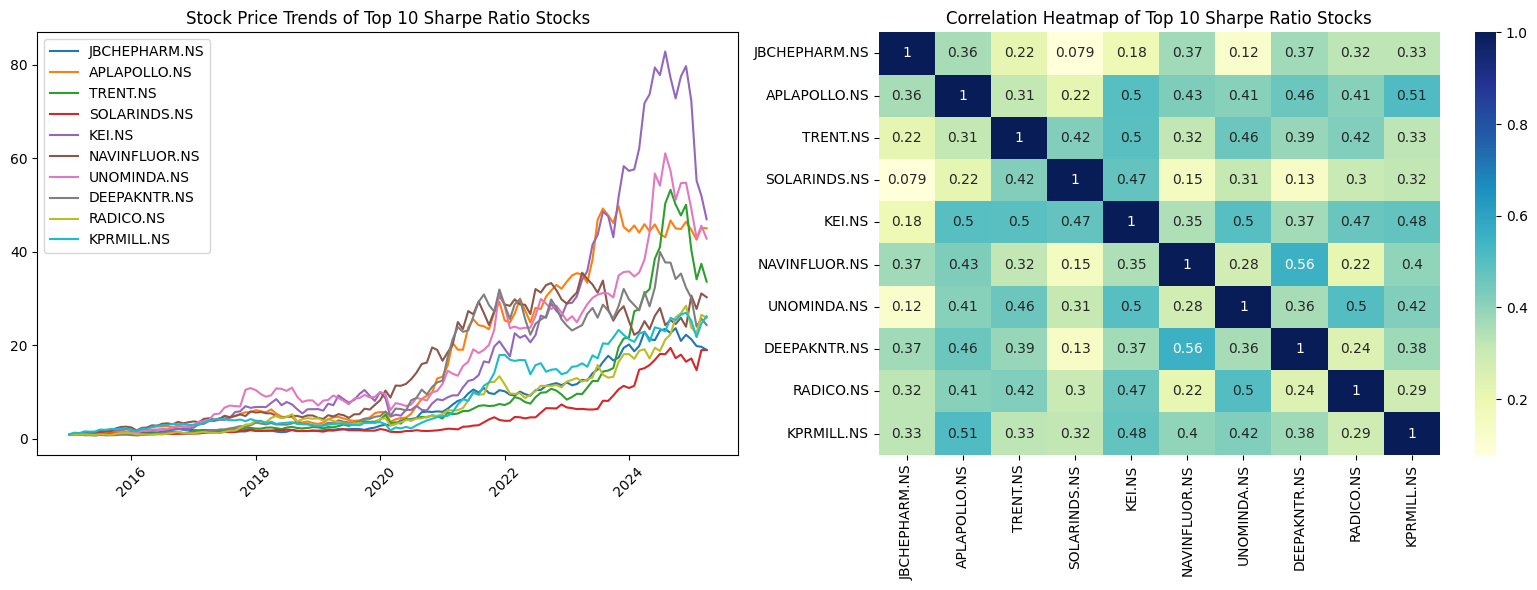

In [14]:
# Step 5: Select top 10 stocks by annualized Sharpe Ratio
top_10_stocks = annual_sharpe_ratios.nlargest(10).index
print("Selected Top 10 Stocks:", list(top_10_stocks))

# Step 6: Plot normalized stock prices and correlation heatmap
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Normalize prices (first month = 1)
for stock in top_10_stocks:
    ax1.plot(df[stock] / df[stock].iloc[0], label=stock)

ax1.set_title("Stock Price Trends of Top 10 Sharpe Ratio Stocks")
ax1.legend(loc="upper left")
ax1.xaxis.set_tick_params(rotation=45)

# Compute log returns of selected top stocks
log_returns_selected = np.log(df[top_10_stocks] / df[top_10_stocks].shift(1)).dropna()

# Plot correlation heatmap
sns.heatmap(log_returns_selected.corr(), annot=True, cmap="YlGnBu", ax=ax2)
ax2.set_title("Correlation Heatmap of Top 10 Sharpe Ratio Stocks")

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Step 1: Use top 10 stocks from annualized Sharpe Ratio
returns_selected = returns[top_10_stocks]  # 'returns' already computed as log monthly returns

# Step 2: Mean and Covariance of monthly returns
mean_returns = returns_selected.mean()
cov_matrix = returns_selected.cov()

# Step 3: Use monthly risk-free rate from compounding
annual_rf = 0.06
monthly_rf = (1 + annual_rf)**(1/12) - 1

# Step 4: Portfolio metrics using annualized return and std dev
def portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate):
    port_return = np.sum(weights * mean_returns) * 12  # Annualized Return
    port_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))  # Annualized Risk
    sharpe_ratio = (port_return - risk_free_rate) / port_stddev
    return port_return, port_stddev, sharpe_ratio

# Step 5: Objective - Maximize Sharpe Ratio ⇒ minimize its negative
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Step 6: Optimization constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # sum of weights = 1
bounds = tuple((0, 1) for _ in range(len(top_10_stocks)))       # weights between 0 and 1
init_guess = np.ones(len(top_10_stocks)) / len(top_10_stocks)   # equal weights initially

# Step 7: Run the optimization
optimal_result = minimize(
    neg_sharpe_ratio, init_guess,
    args=(mean_returns, cov_matrix, annual_rf),
    method='SLSQP', bounds=bounds, constraints=constraints
)

# Step 8: Extract optimal weights and compute final portfolio metrics
optimal_weights = optimal_result.x
port_return, port_stddev, sharpe_ratio = portfolio_metrics(
    optimal_weights, mean_returns, cov_matrix, annual_rf
)

# Step 9: Display results
optimal_portfolio = pd.DataFrame({'Stock': top_10_stocks, 'Weight': optimal_weights})
print("Optimal Portfolio Allocation:\n")
print(optimal_portfolio)

print(f"\nPortfolio Expected Annual Return: {port_return:.4f}")
print(f"Portfolio Annualized Risk (Std Dev): {port_stddev:.4f}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")


Optimal Portfolio Allocation:

           Stock        Weight
0  JBCHEPHARM.NS  3.499172e-01
1   APLAPOLLO.NS  1.302354e-01
2       TRENT.NS  8.773402e-02
3   SOLARINDS.NS  2.515059e-01
4         KEI.NS  9.703609e-18
5  NAVINFLUOR.NS  8.426530e-02
6    UNOMINDA.NS  9.634222e-02
7   DEEPAKNTR.NS  8.131516e-19
8      RADICO.NS  2.406929e-17
9     KPRMILL.NS  0.000000e+00

Portfolio Expected Annual Return: 0.3146
Portfolio Annualized Risk (Std Dev): 0.2044
Portfolio Sharpe Ratio: 1.2458


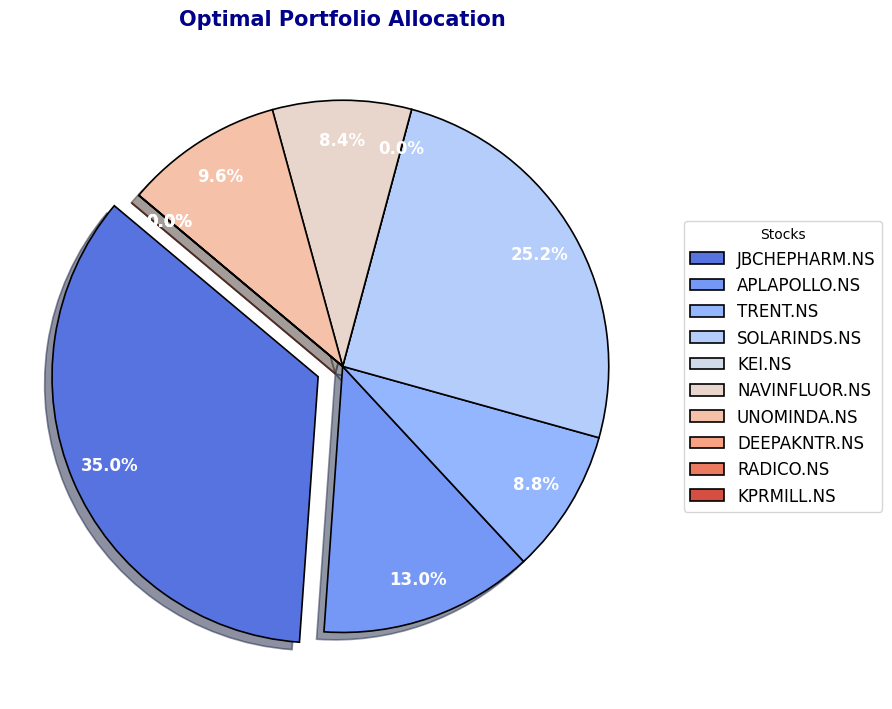

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define explode effect for largest allocation
explode = [0.1 if w == max(optimal_weights) else 0 for w in optimal_weights]

# Use a visually appealing color palette
colors = sns.color_palette("coolwarm", len(top_10_stocks))

# Create the pie chart
plt.figure(figsize=(9, 9))

wedges, texts, autotexts = plt.pie(
    optimal_weights,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=140,
    shadow=True,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.2},
    pctdistance=0.85
)

# Add a legend (instead of cluttered labels)
plt.legend(
    wedges,
    top_10_stocks,
    title="Stocks",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12
)

# Enhance the text style for percentages
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')
    autotext.set_color("white")

# Add chart title
plt.title("Optimal Portfolio Allocation", fontsize=15, fontweight='bold', color='darkblue')

# Show the plot
plt.tight_layout()
plt.show()


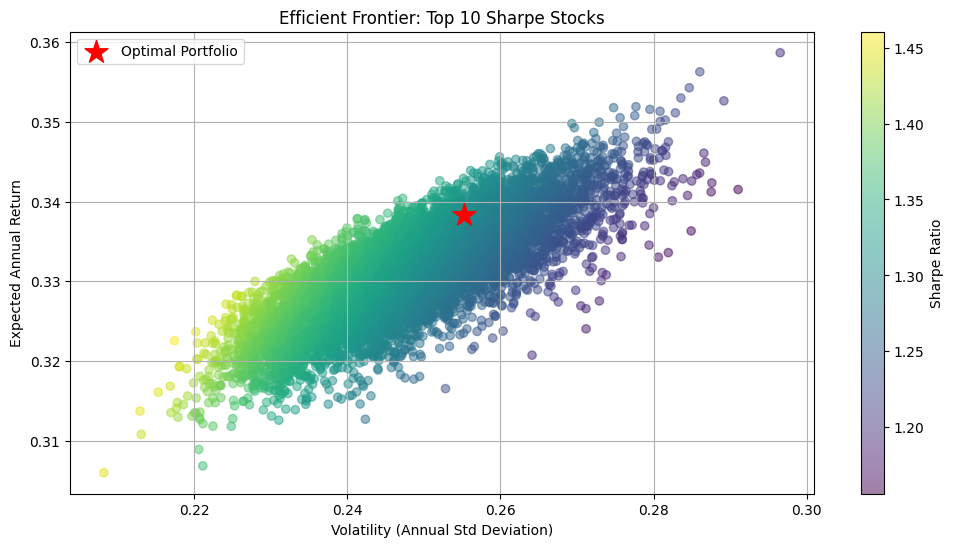

In [17]:
import matplotlib.pyplot as plt

# Generate Random Portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # Rows: Return, Std Dev, Sharpe
weights_record = []

for i in range(num_portfolios):
    # Random Weights
    weights = np.random.random(len(top_10_stocks))
    weights /= np.sum(weights)

    # Portfolio Metrics: Annualized
    port_return, port_stddev, sharpe = portfolio_metrics(weights, mean_returns, cov_matrix, risk_free_rate)

    # Store Results
    results[0, i] = port_return
    results[1, i] = port_stddev
    results[2, i] = sharpe
    weights_record.append(weights)

# Plot Efficient Frontier
plt.figure(figsize=(12, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility (Annual Std Deviation)')
plt.ylabel('Expected Annual Return')

# Highlight the Optimal Portfolio
plt.scatter(port_stddev, port_return, c='red', marker='*', s=300, label='Optimal Portfolio')
plt.legend()
plt.title('Efficient Frontier: Top 10 Sharpe Stocks')
plt.grid(True)
plt.show()


<ipython-input-18-7db523004329>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_return = mean_returns[i]


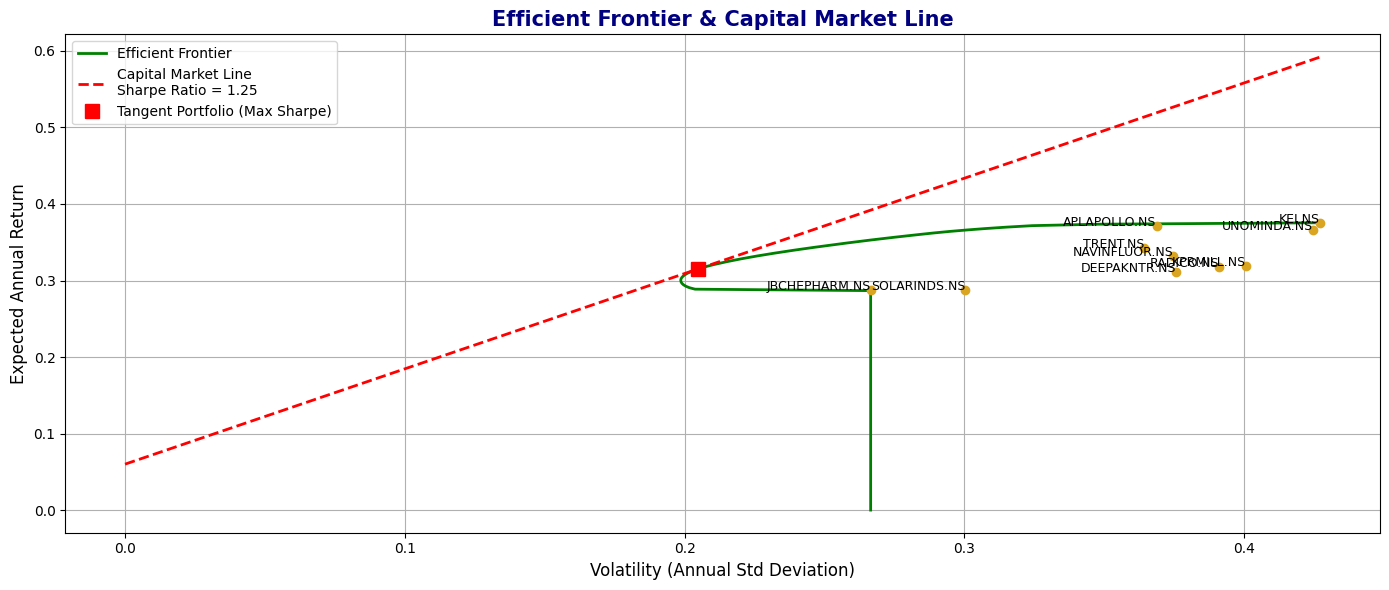

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data for only the top 10 stocks
returns_10 = returns[top_10_stocks]
mean_returns = returns_10.mean() * 12  # Annualized expected returns
cov_matrix = returns_10.cov() * 12     # Annualized covariance matrix

risk_free_rate = 0.06  # Annual risk-free rate
samples = 200  # granularity of the efficient frontier

target_returns = np.linspace(0, np.max(mean_returns), samples)
volatilities = np.zeros_like(target_returns)
sharpe_ratios = np.zeros_like(target_returns)

# Function to calculate optimal weights for a given target return
def optimizer(mu, cov, target_return):
    from scipy.optimize import minimize

    n = len(mu)
    init_guess = np.ones(n) / n
    bounds = tuple((0, 1) for _ in range(n))
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: w @ mu - target_return}
    )

    def portfolio_volatility(w):
        return np.sqrt(w @ cov @ w)

    result = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Compute Efficient Frontier
for i, target in enumerate(target_returns):
    weights_opt = optimizer(mean_returns.values, cov_matrix.values, target)
    volatilities[i] = np.sqrt(weights_opt @ cov_matrix.values @ weights_opt)
    sharpe_ratios[i] = (target - risk_free_rate) / volatilities[i]

# Identify the Tangent Portfolio (max Sharpe Ratio)
idx_max_sr = np.argmax(sharpe_ratios)
max_sharpe = sharpe_ratios[idx_max_sr]
cml_x = np.linspace(0, np.max(volatilities), samples)
cml_y = risk_free_rate + max_sharpe * cml_x  # Capital Market Line

# Plot Efficient Frontier & Capital Market Line
plt.figure(figsize=(14, 6))
plt.plot(volatilities, target_returns, label='Efficient Frontier', color='green', linewidth=2)
plt.plot(cml_x, cml_y, 'r--', label=f'Capital Market Line\nSharpe Ratio = {max_sharpe:.2f}', linewidth=2)

# Annotate Individual Stocks
for i, stock in enumerate(top_10_stocks):
    stock_std = np.sqrt(cov_matrix.iloc[i, i])
    stock_return = mean_returns[i]
    plt.plot(stock_std, stock_return, 'o', color='goldenrod')
    plt.annotate(stock, (stock_std, stock_return), fontsize=9, ha='right')

# Highlight Tangent Portfolio
plt.plot(volatilities[idx_max_sr], target_returns[idx_max_sr], 'rs', markersize=10, label='Tangent Portfolio (Max Sharpe)')

# Final Touches
plt.title('Efficient Frontier & Capital Market Line', fontsize=15, fontweight='bold', color='navy')
plt.xlabel('Volatility (Annual Std Deviation)', fontsize=12)
plt.ylabel('Expected Annual Return', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Calculate optimal weights at Max Sharpe Ratio
tangent_weights = optimizer(mean_returns.values, cov_matrix.values, target_returns[idx_max_sr])

# Create a DataFrame for better display
import pandas as pd
weights_df = pd.DataFrame([dict(zip(top_10_stocks, tangent_weights.round(4)))])
weights_df.index = ["Tangent Portfolio Weights"]

# Display the weights
print("\nOptimal Weights for Tangent Portfolio (Max Sharpe Ratio):")
display(weights_df)



Optimal Weights for Tangent Portfolio (Max Sharpe Ratio):


,JBCHEPHARM.NS,APLAPOLLO.NS,TRENT.NS,SOLARINDS.NS,KEI.NS,NAVINFLUOR.NS,UNOMINDA.NS,DEEPAKNTR.NS,RADICO.NS,KPRMILL.NS
Tangent Portfolio Weights,0.3462,0.1344,0.0883,0.2487,0.0,0.0844,0.098,0.0,0.0,0.0


In [20]:
sorted_weights_df = weights_df.T.sort_values(by="Tangent Portfolio Weights", ascending=False)
display(sorted_weights_df)


,Tangent Portfolio Weights
JBCHEPHARM.NS,0.3462
SOLARINDS.NS,0.2487
APLAPOLLO.NS,0.1344
UNOMINDA.NS,0.0980
TRENT.NS,0.0883
NAVINFLUOR.NS,0.0844
KEI.NS,0.0000
DEEPAKNTR.NS,0.0000
RADICO.NS,0.0000
KPRMILL.NS,0.0000


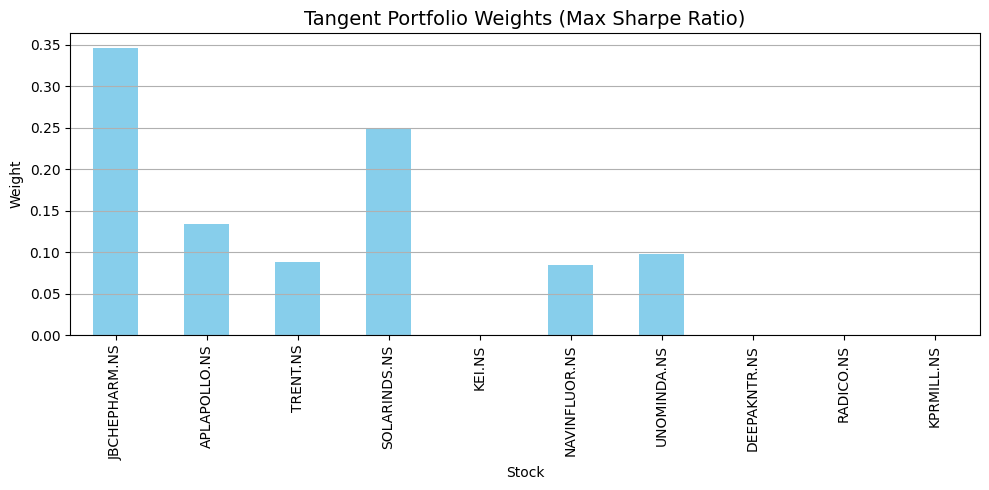

In [21]:
weights_df.T.plot(kind='bar', legend=False, figsize=(10, 5), color='skyblue')
plt.title('Tangent Portfolio Weights (Max Sharpe Ratio)', fontsize=14)
plt.ylabel('Weight')
plt.xlabel('Stock')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, LinearConstraint

# Variables from your analysis
MU = mean_returns.values  # Expected returns of 10 selected stocks
COV = cov_matrix.values   # Covariance matrix of 10 selected stocks
Rf = 0.06                 # Risk-free rate (you can adjust this)

N = len(MU)

# Initial guess: equal weights
x0 = np.ones(N) / N

# Objective function: negative Sharpe Ratio
sharpe_fun = lambda w: -(MU @ w - Rf) / np.sqrt(w.T @ COV @ w)

# Constraints: weights sum to 1
bounds = Bounds(0, 1)
linear_constraint = LinearConstraint(np.ones(N), 1, 1)

# Optimization
res = minimize(sharpe_fun, x0=x0, method="trust-constr", constraints=linear_constraint, bounds=bounds)

# Extract optimal weights
w_sr = res.x

# Display results
print("Weights for the Tangent Portfolio:")
display(pd.DataFrame([dict(zip(top_10_stocks, w_sr.round(4)))]))

# Sharpe ratio and stats
max_sharpe = -sharpe_fun(w_sr)
portfolio_std = np.sqrt(w_sr @ COV @ w_sr)
portfolio_mean = MU @ w_sr

print(f"\nMax Sharpe Ratio = {max_sharpe:.4f}")
print(f"Optimal Portfolio: σ = {portfolio_std:.4f}, μ = {portfolio_mean:.4f}")


Weights for the Tangent Portfolio:


,JBCHEPHARM.NS,APLAPOLLO.NS,TRENT.NS,SOLARINDS.NS,KEI.NS,NAVINFLUOR.NS,UNOMINDA.NS,DEEPAKNTR.NS,RADICO.NS,KPRMILL.NS
0,0.35,0.1302,0.0877,0.2516,0.0,0.0843,0.0963,0.0,0.0,0.0



Max Sharpe Ratio = 1.2458
Optimal Portfolio: σ = 0.2043, μ = 0.3146


In [4]:
print(top_10_prices.head())

            JBCHEPHARM.NS  APLAPOLLO.NS    TRENT.NS  SOLARINDS.NS     KEI.NS  \
Date                                                                           
2015-01-01      82.480179     33.803726  142.331985    593.353027  55.638397   
2015-02-01      82.631447     32.426575  145.537109    634.229736  54.862946   
2015-03-01      86.196854     37.639076  143.405258    651.146912  60.339550   
2015-04-01      93.695061     40.943302  111.100533    648.199768  69.402588   
2015-05-01     103.505363     40.661301  116.232605    662.945007  71.438148   

            NAVINFLUOR.NS  UNOMINDA.NS  DEEPAKNTR.NS  RADICO.NS  KPRMILL.NS  
Date                                                                         
2015-01-01     135.466339    19.223166     77.195129  91.596237   36.783375  
2015-02-01     131.660324    19.519960     69.671867  84.226433   48.801548  
2015-03-01     155.127686    18.186970     64.017731  85.709969   45.070992  
2015-04-01     154.162262    16.912041     64.485

In [4]:
top_10_prices.to_csv('output.csv', index=False)  # index=False to prevent writing the DataFrame index

In [9]:
weights = np.array([0.3462, 0.1344, 0.0883, 0.2487, 0.0, 0.0844, 0.098, 0.0, 0.0, 0.0])


In [6]:
import pandas as pd
import numpy as np

# Load final CSV file
df = pd.read_csv("final_df.csv", index_col="Date", parse_dates=True)

# Separate market and stocks
market_column = "MARKET"  # Adjust if named differently
stock_data = df.drop(columns=[market_column])
market_data = df[market_column]

# Calculate log returns
returns = np.log(df / df.shift(1)).dropna()
stock_returns = returns.drop(columns=[market_column])
market_returns = returns[market_column]


In [7]:
expected_returns = stock_returns.mean()
std_devs = stock_returns.std()

# Annualize
expected_annual_returns = expected_returns * 12
annual_std_devs = std_devs * np.sqrt(12)


In [10]:
# Use only selected stocks with non-zero weights
selected_stocks = stock_returns.columns[weights > 0]
selected_weights = weights[weights > 0]
selected_returns = stock_returns[selected_stocks]

# Portfolio expected return and risk
portfolio_return = np.dot(selected_weights, expected_annual_returns[selected_stocks])
portfolio_risk = np.sqrt(np.dot(selected_weights.T, np.dot(selected_returns.cov() * 12, selected_weights)))


In [11]:
# Beta of each stock = Cov(stock, market) / Var(market)
stock_betas = {}
market_var = market_returns.var()

for stock in selected_stocks:
    cov = np.cov(stock_returns[stock], market_returns)[0, 1]
    beta = cov / market_var
    stock_betas[stock] = beta

# Portfolio beta = weighted average of stock betas
portfolio_beta = sum(stock_betas[stock] * w for stock, w in zip(selected_stocks, selected_weights))


In [12]:
# Assume annual risk-free rate = 6%
annual_rf = 0.06

# Annual market return
annual_market_return = market_returns.mean() * 12

# Market risk premium
market_risk_premium = annual_market_return - annual_rf

# Risk premium = Beta * Market Risk Premium
stock_risk_premiums = {stock: b * market_risk_premium for stock, b in stock_betas.items()}
portfolio_risk_premium = portfolio_beta * market_risk_premium


In [13]:
total_investment = 100000
investment_allocation = {stock: total_investment * w for stock, w in zip(selected_stocks, selected_weights)}


In [14]:
print("Portfolio Expected Annual Return:", round(portfolio_return * 100, 2), "%")
print("Portfolio Risk (Std Dev):", round(portfolio_risk * 100, 2), "%")
print("Portfolio Beta:", round(portfolio_beta, 4))
print("Portfolio Risk Premium:", round(portfolio_risk_premium * 100, 2), "%")
print("\nStock-wise Details:\n")

for stock in selected_stocks:
    print(f"{stock}:")
    print(f"  Expected Annual Return: {expected_annual_returns[stock]*100:.2f}%")
    print(f"  Annual Std Dev: {annual_std_devs[stock]*100:.2f}%")
    print(f"  Beta: {stock_betas[stock]:.4f}")
    print(f"  Risk Premium: {stock_risk_premiums[stock]*100:.2f}%")
    print(f"  Investment: ${investment_allocation[stock]:.2f}\n")


Portfolio Expected Annual Return: 31.51 %
Portfolio Risk (Std Dev): 20.48 %
Portfolio Beta: 0.8452
Portfolio Risk Premium: 3.7 %

Stock-wise Details:

JBCHEPHARM.NS:
  Expected Annual Return: 28.72%
  Annual Std Dev: 26.65%
  Beta: 0.4762
  Risk Premium: 2.08%
  Investment: $34620.00

APLAPOLLO.NS:
  Expected Annual Return: 37.14%
  Annual Std Dev: 36.87%
  Beta: 1.1899
  Risk Premium: 5.20%
  Investment: $13440.00

TRENT.NS:
  Expected Annual Return: 34.29%
  Annual Std Dev: 36.43%
  Beta: 1.2411
  Risk Premium: 5.43%
  Investment: $8830.00

SOLARINDS.NS:
  Expected Annual Return: 28.74%
  Annual Std Dev: 30.03%
  Beta: 0.7946
  Risk Premium: 3.48%
  Investment: $24870.00

NAVINFLUOR.NS:
  Expected Annual Return: 33.27%
  Annual Std Dev: 37.47%
  Beta: 0.9493
  Risk Premium: 4.15%
  Investment: $8440.00

UNOMINDA.NS:
  Expected Annual Return: 36.65%
  Annual Std Dev: 42.46%
  Beta: 1.3582
  Risk Premium: 5.94%
  Investment: $9800.00



In [15]:
summary_df = pd.DataFrame({
    'Expected Return (%)': expected_annual_returns[selected_stocks]*100,
    'Std Dev (%)': annual_std_devs[selected_stocks]*100,
    'Beta': [stock_betas[stock] for stock in selected_stocks],
    'Risk Premium (%)': [stock_risk_premiums[stock]*100 for stock in selected_stocks],
    'Investment ($)': [investment_allocation[stock] for stock in selected_stocks]
})

summary_df.to_csv("Portfolio_Analysis.csv")


<ipython-input-16-8d5cd677782a>:8: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


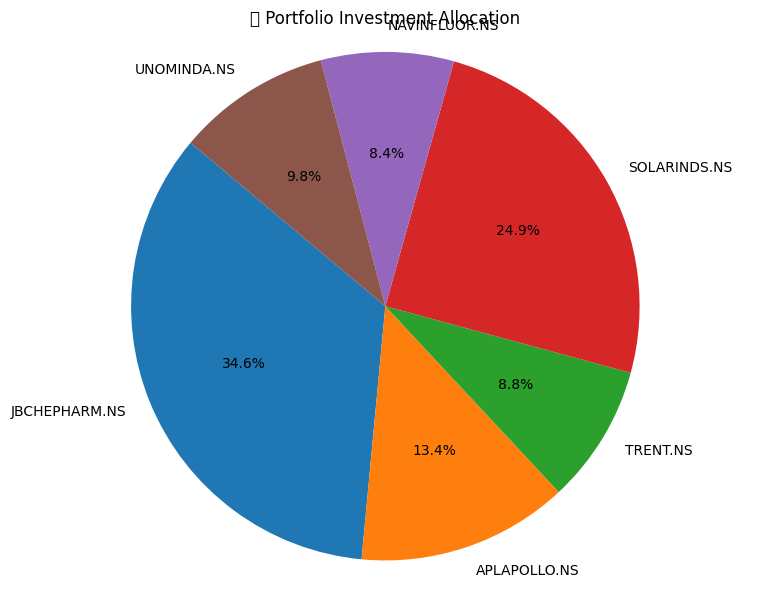

In [16]:
import matplotlib.pyplot as plt

# Pie chart for investment allocation
plt.figure(figsize=(8, 6))
plt.pie(investment_allocation.values(), labels=investment_allocation.keys(), autopct='%1.1f%%', startangle=140)
plt.title("💰 Portfolio Investment Allocation")
plt.axis('equal')
plt.tight_layout()
plt.show()


<ipython-input-17-40a1943f8d82>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


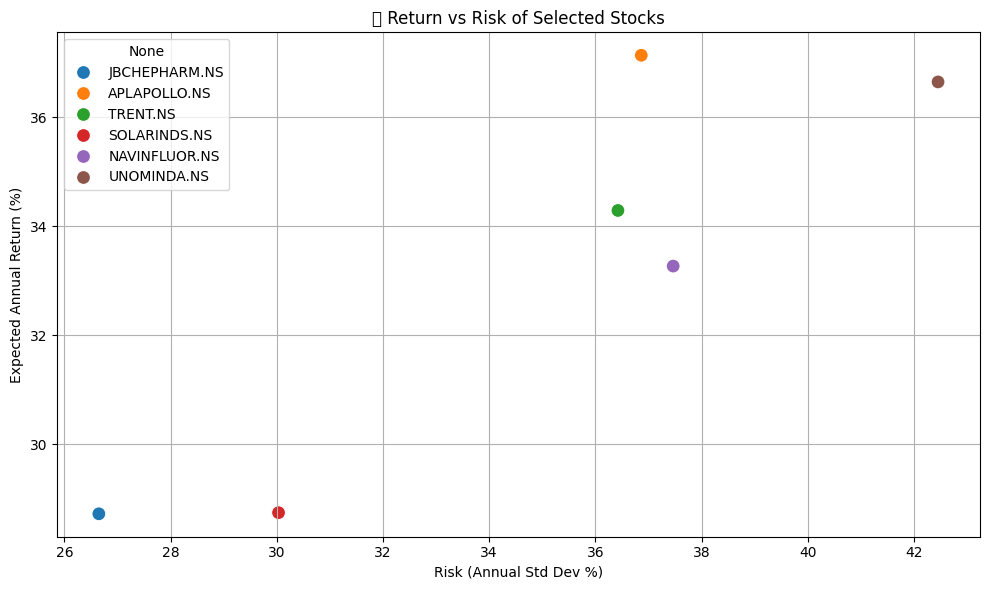

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=annual_std_devs[selected_stocks]*100,
    y=expected_annual_returns[selected_stocks]*100,
    hue=selected_stocks,
    s=100
)
plt.xlabel("Risk (Annual Std Dev %)")
plt.ylabel("Expected Annual Return (%)")
plt.title("📈 Return vs Risk of Selected Stocks")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-18-2ffe550a3643>:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


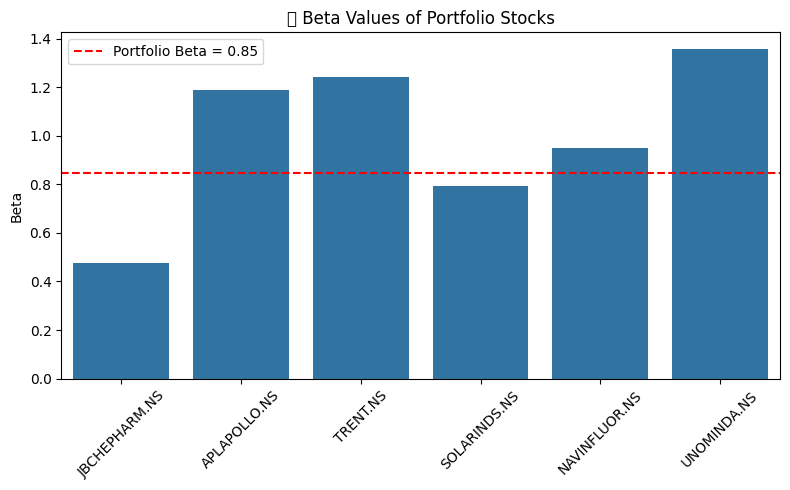

In [18]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(stock_betas.keys()), y=list(stock_betas.values()))
plt.axhline(portfolio_beta, color='red', linestyle='--', label=f"Portfolio Beta = {portfolio_beta:.2f}")
plt.ylabel("Beta")
plt.title("📊 Beta Values of Portfolio Stocks")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


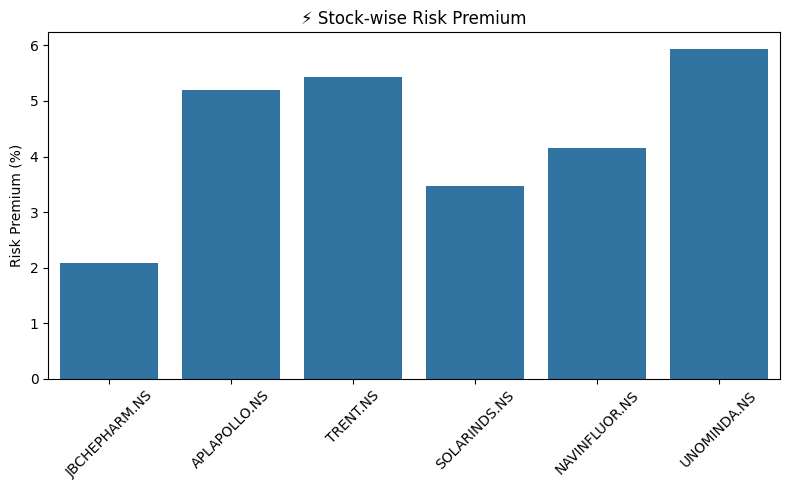

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(stock_risk_premiums.keys()), y=[v*100 for v in stock_risk_premiums.values()])
plt.ylabel("Risk Premium (%)")
plt.title("⚡ Stock-wise Risk Premium")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-20-cf7b0ae5fb88>:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


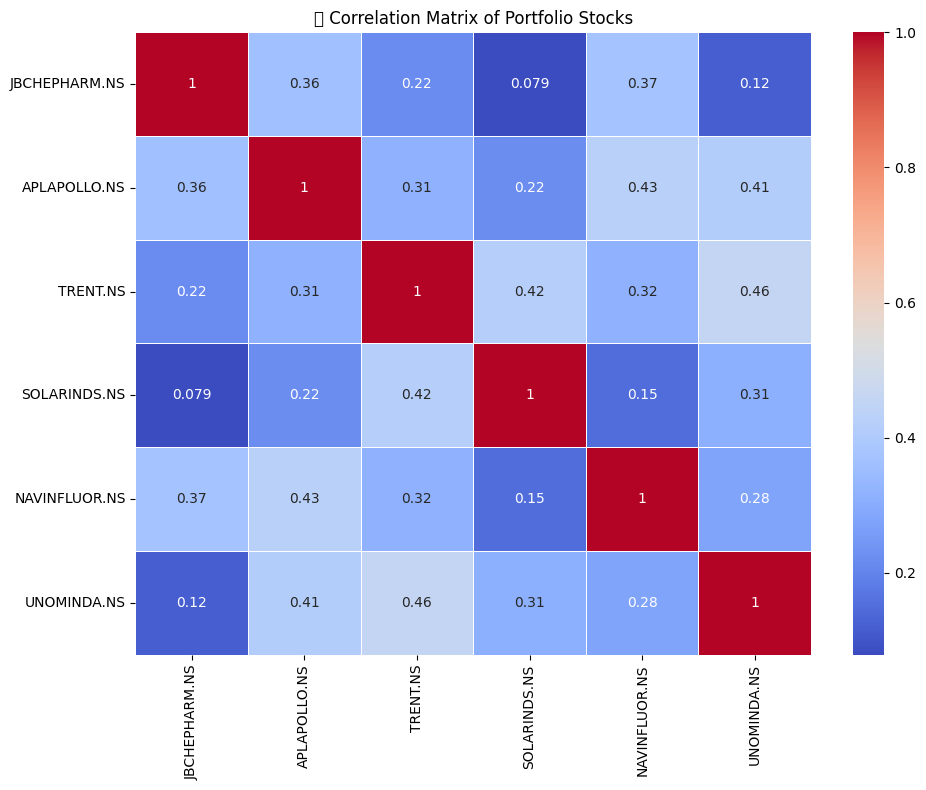

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(selected_returns.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("📊 Correlation Matrix of Portfolio Stocks")
plt.tight_layout()
plt.show()
